# POC......

In [1]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
import os
import matplotlib.pyplot as plt

In [2]:
# Load the MNIST dataset
(x_train, y_train), (x_test, y_test) = tf.keras.datasets.mnist.load_data()

In [3]:
dataset = tf.data.Dataset.from_tensor_slices((x_train,y_train))


In [4]:
# Define the path for saving the raw_data_save_path
raw_data_save_path = os.path.join("..", "data/raw", "MNSIT_RAW") 

# Ensure the directory exists
os.makedirs(os.path.dirname(raw_data_save_path), exist_ok=True)

tf.data.Dataset.save(dataset,raw_data_save_path)

In [5]:
def preprocess_dataset(images, labels, batch_size=32, shuffle=True, augment=False, flatten=False):
    # Convert to float32 and normalize
    def normalize(image, label):
        image = tf.cast(image, tf.float32) / 255.0
        return image, label
    
    # Create dataset
    dataset = tf.data.Dataset.from_tensor_slices((images, labels))
    
    # Reshape the input data to match the expected shape
    dataset = dataset.map(lambda x, y: (tf.reshape(x, (-1, 28, 28, 1)), y))

    # Shuffle the dataset if required
    if shuffle:
        dataset = dataset.shuffle(buffer_size=10000)
        
    # Apply augmentation if required
    if augment:
        dataset = dataset.map(augment_fn, num_parallel_calls=tf.data.AUTOTUNE)        
        
    # flatten the dataset if required
    if flatten:
        dataset = dataset.map(lambda image, label: (tf.reshape(image, [-1]), label), num_parallel_calls=tf.data.AUTOTUNE)
        
    # Apply normalization (and flattening if required)
    dataset = dataset.map(normalize, num_parallel_calls=tf.data.AUTOTUNE)

    # Batch the dataset
    dataset = dataset.batch(batch_size)

    # Prefetch for performance
    dataset = dataset.prefetch(tf.data.AUTOTUNE)

    return dataset
# Augmentation function 
def augment_fn(image, label):
    # Ensure the image is in float32 format and add a channel dimension
    image = tf.cast(image, tf.float32)
    image = tf.expand_dims(image, axis=-1)
    
    # Random rotation (reduced probability)
    if tf.random.uniform(()) < 0.25:
        image = tf.image.rot90(image, k=tf.random.uniform(shape=[], minval=0, maxval=4, dtype=tf.int32))
    
    # Random flip left-right (reduced probability)
    if tf.random.uniform(()) < 0.25:
        image = tf.image.random_flip_left_right(image)
    
    # Random brightness adjustment (reduced range)
    image = tf.image.random_brightness(image, max_delta=0.05)
    
    # Random contrast adjustment (narrower range)
    image = tf.image.random_contrast(image, lower=0.95, upper=1.05)
    
    # Ensure pixel values are still in [0, 1] range
    image = tf.clip_by_value(image, 0.0, 1.0)
    
    # Remove the added channel dimension
    image = tf.squeeze(image, axis=-1)
    return image, label

In [6]:
# Preprocess training and test datasets
train_dataset = preprocess_dataset(x_train, y_train, shuffle=True,batch_size=32, augment=False, flatten=True)
test_dataset = preprocess_dataset(x_test, y_test, shuffle=False, batch_size=32, augment=False, flatten=True)

In [7]:
# Define the path for saving the Processed_data
Train_Processed_data_save_path = os.path.join("..", "data/Processed", "MNSIT_Train_Processed") 
Test_Processed_data_save_path = os.path.join("..", "data/Processed", "MNSIT_Test_Processed") 

# Ensure the directory exists
os.makedirs(os.path.dirname(Train_Processed_data_save_path), exist_ok=True)
os.makedirs(os.path.dirname(Test_Processed_data_save_path), exist_ok=True)


tf.data.Dataset.save(train_dataset,Train_Processed_data_save_path)
tf.data.Dataset.save(test_dataset,Test_Processed_data_save_path)

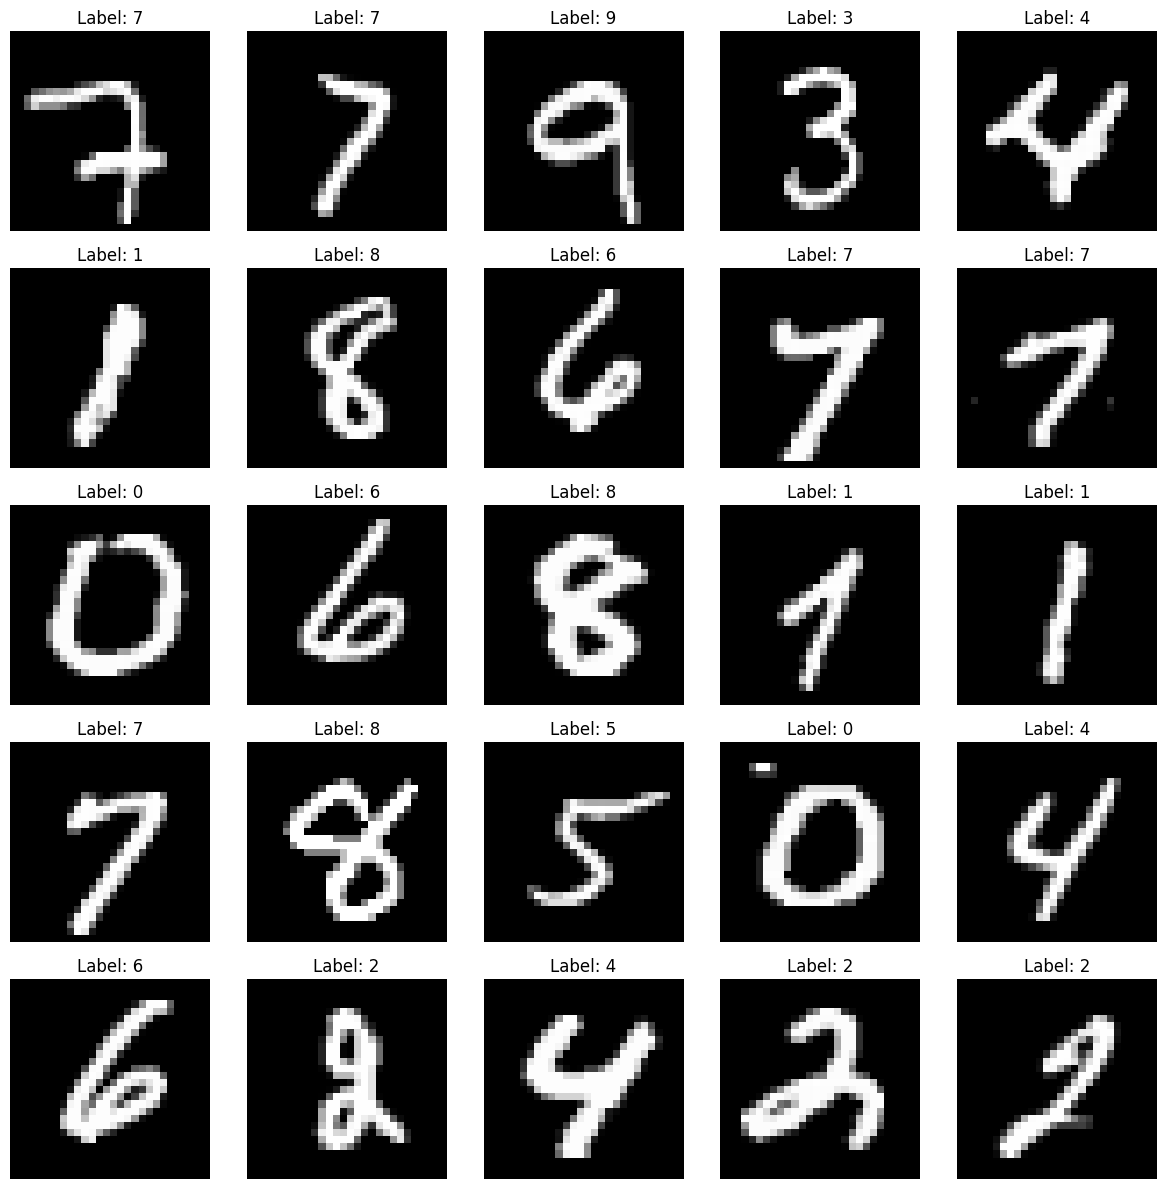

Images shape: (32, 784)
Labels shape: (32,)


In [8]:
# Visualize some samples from the train_dataset
import matplotlib.pyplot as plt

# Take a batch from the dataset
images, labels = next(iter(train_dataset))

# Plot the first 25 images
fig, axes = plt.subplots(5, 5, figsize=(12, 12))
for i, ax in enumerate(axes.flat):
    if i < 25:
        ax.imshow(images[i].numpy().reshape(28, 28), cmap='gray')
        ax.set_title(f"Label: {labels[i].numpy()}")
        ax.axis('off')
plt.tight_layout()
plt.show()

# Print the shape of the images and labels
print("Images shape:", images.shape)
print("Labels shape:", labels.shape)

In [9]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout, Reshape

def create_model():
    model = Sequential([
        Reshape((28, 28, 1), input_shape=(784,)),  # Add this layer to reshape the input
        Conv2D(32, (3, 3), activation='relu'),
        MaxPooling2D(pool_size=(2, 2)),
        Conv2D(64, (3, 3), activation='relu'),
        MaxPooling2D(pool_size=(2, 2)),
        Flatten(),
        Dense(128, activation='relu'),
        Dropout(0.5),
        Dense(10, activation='softmax')
    ])
    return model

model = create_model()
model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])


d:\Projects\AI Tutorials\TensorFlow\CNN MNSIT Project\venv\Lib\site-packages\keras\src\layers\reshaping\reshape.py:39: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


In [10]:
# Fit the model using the separate train and validation datasets
model.fit(train_dataset, epochs=5)


Epoch 1/5
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 12s 6ms/step - accuracy: 0.8548 - loss: 0.4484
Epoch 2/5
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 11s 6ms/step - accuracy: 0.9736 - loss: 0.0883
Epoch 3/5
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 11s 6ms/step - accuracy: 0.9818 - loss: 0.0626
Epoch 4/5
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 11s 6ms/step - accuracy: 0.9857 - loss: 0.0470
Epoch 5/5
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 11s 6ms/step - accuracy: 0.9880 - loss: 0.0396


In [11]:
loss, accuracy = model.evaluate(test_dataset)
print(f"Test Accuracy: {accuracy * 100:.2f}%")


313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.9887 - loss: 0.0340
Test Accuracy: 99.17%


In [12]:
# Define the path for saving the model
model_save_path = os.path.join("..", "models\saved_models", "mnist_cnn_model.keras")

# Ensure the directory exists
os.makedirs(os.path.dirname(model_save_path), exist_ok=True)

# Save the model
model.save(model_save_path)


___________________

# Testing The Modular code....

In [18]:
from src.data.dataset_operations import make_dataset , load_dataset
training_dataset, testing_dataset = load_dataset()

In [19]:
from src.models.model_operations import train_model, evaluate_model
model, history = train_model(training_dataset=training_dataset)
Test_Accuracy = evaluate_model(model=model, testing_dataset= testing_dataset)
print("Model trained and saved successfully.")

Epoch 1/5


d:\Projects\AI Tutorials\TensorFlow\CNN MNSIT Project\venv\Lib\site-packages\keras\src\layers\reshaping\reshape.py:39: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


1875/1875 ━━━━━━━━━━━━━━━━━━━━ 12s 6ms/step - accuracy: 0.8722 - loss: 0.4094
Epoch 2/5
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 11s 6ms/step - accuracy: 0.9762 - loss: 0.0779
Epoch 3/5
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 11s 6ms/step - accuracy: 0.9848 - loss: 0.0528
Epoch 4/5
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 11s 6ms/step - accuracy: 0.9868 - loss: 0.0438
Epoch 5/5
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 11s 6ms/step - accuracy: 0.9888 - loss: 0.0373
313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.9874 - loss: 0.0444
Model trained and saved successfully.


In [20]:
print(Test_Accuracy)

{'Test Accuracy', 99.01999831199646}


In [1]:
from src.models.model_operations import train_model, evaluate_model, load_model, predict

model = load_model()

In [1]:
from src.models.model_operations import train_model, evaluate_model, load_model, predict
from src.data.data_preprocessing import preprocess_predicted_image
# Usage example
image_path = r'..\data\uploaded\3.png'
processed_image = preprocess_predicted_image(image_path= image_path)
predictions = predict(processed_image)
print(predictions)

AttributeError: 'NoneType' object has no attribute 'Rlocation'